## Close budget in T and S space with the gateway transports

- prove physical consistency between the Northern Barents Sea and the whole Barents Sea for BSO heat transport (this will help validate the mask and show heat loss in the Southern Barents Sea)
- map the overall tend -- show the terms in map view with the SI extent so we can see WHERE these things are happening

In [7]:
# load the packages and functions

# auto-reload edited moduleås
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from adv_closure_TS import *

In [9]:
# set the correct directories based on official ASTE
forward_path = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirdiags = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/BUDG/"
dirstate = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/STATE/"

# layers path here is for what time steps?
layers_path2007 = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
layers_path2016 = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2016_capxxN50_it0062_pk0000736272_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"


In [10]:
forward_path

'/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/'

In [11]:
# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

# load the indices from file
data = np.load("/home/mmurakami/crios_backups/an_helper_functions/gates_BSO.npz")

y_bsoh, x_bsoh = data["y_bsoh"], data["x_bsoh"]
y_bsov, x_bsov = data["y_bsov"], data["x_bsov"]

y_fjnzv, x_fjnzv = data["y_fjnzv"], data["x_fjnzv"]
y_fjnz,  x_fjnz  = data["y_fjnz"],  data["x_fjnz"]

y_nzruv, x_nzruv = data["y_nzruv"], data["x_nzruv"]

y_spfjh, x_spfjh = data["y_spfjh"], data["x_spfjh"]
y_spfjv, x_spfjv = data["y_spfjv"], data["x_spfjv"]
y_spfjb, x_spfjb = data["y_spfjb"], data["x_spfjb"]

print("keys:", list(data.keys()))


# 01.22.26: define another gateway midpoint, need to include this in gate functions and add a flag to the gates_check function

keys: ['y_bsoh', 'x_bsoh', 'y_bsov', 'x_bsov', 'y_fjnzv', 'x_fjnzv', 'y_fjnz', 'x_fjnz', 'y_nzruv', 'x_nzruv', 'y_spfjh', 'x_spfjh', 'y_spfjv', 'x_spfjv', 'y_spfjb', 'x_spfjb']


In [12]:
ny

1350

In [13]:
y_spnz = np.arange(485,560,1)
x_spnz = np.full_like(y_spnz,45) 

mymsk2 = np.full((ny,nx),np.nan)
mymsk2[mymsk == 1] = 1
mymsk2[:,:45] = np.nan
mymsk2[:,100:] = np.nan

In [14]:
# let's move the gate calculation to a function to show a timeseries
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

In [15]:
# also load the bins again so we have them locally
## load the TS bins
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

## random plotting tool copied over

In [16]:
# fig = plt.figure()
# terms = np.array(["ADVr","DFh","DFr","surf","kpp"])

# ax = plt.subplot(311)

# ax.plot(boundsT.flatten()[1:-1],np.nansum(G_T_offline_new[:-1],axis=0),linewidth=3,label="sum of terms")                 # the terms contributing to temperature
# ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[-1],label='tend',alpha=0.8)  # total tendency as calculated from snaps
# ax.legend(loc="best")
# ax.set_ylabel("m^3/s")
# ax.set_xlabel("T")

# ax = plt.subplot(312)
# for i in range(1,6):
#     ax.plot(boundsT.flatten()[1:-1],dF_Tnew[i],label=terms[i-1])                 # the terms contributing to temperature
# ax.plot(boundsT.flatten()[1:-1],dF_Tnew[-1],label='tend',alpha=0.5)  # total tendency as calculated from snaps
# ax.legend(loc="best")
# ax.set_ylabel("m^3/s")
# ax.set_xlabel("T")

# ax = plt.subplot(313)

# ax.plot(boundsT.flatten()[1:-1],G_BSOT/binwidthT1,label="BSO")
# ax.plot(boundsT.flatten()[1:-1],G_FJNZT/binwidthT1,label="FJNZ")
# ax.plot(boundsT.flatten()[1:-1],G_SPFJT/binwidthT1,label="SPFJ")
# ax.plot(boundsT.flatten()[1:-1],G_NZRUT/binwidthT1,label="NZRU")
# ax.legend(loc="best")
# ax.set_ylabel("m^3/s")
# ax.set_xlabel("T")

## FOR ONE YEAR, show this is budgeted and plot a sample T and S budget

An will not like this, but this will help to show closure and see the seasons.

From this we can also create a climatology which will be the comparison we make 

In [17]:
# Let's try to run this for the year 2007
# eventually we want to run this for the whole series. we can do so below

In [11]:
# let's move the gate calculation to a function to show a timeseries
# define tstep

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
# times['2007'] = np.arange(1,5,1)  # two timesteps only, cool this works, now plot all
# times['2008'] = np.array([1])
times['2007'] = np.arange(1,13,1)
times['2008'] = np.array([1])

# the filenames we want for 2014
tsstrfull,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstrfull

array(['0000262944', '0000267408', '0000271440', '0000275904',
       '0000280224', '0000284688', '0000289008', '0000293472',
       '0000297936', '0000302256', '0000306720', '0000311040',
       '0000315504'], dtype='<U32')

In [12]:
# once we make this we will not have time to analyze it so it may be good to take a step back and purely compare
# one time step for 2007 and 2016
# make an array to save all the timesteps (or a dict)
out = {}

for ts in tsstrfull[1:]:
    out[ts] = {}
    out[ts]["Tbudg"] = {}
    out[ts]["Sbudg"] = {}
    out[ts]["GT"] = {}  # contains ADVh, ADVr, DFh, DFr, surf, kpp, tend
    out[ts]["GS"] = {}
    out[ts]["gatesT"] = {}
    out[ts]["gatesS"] = {}

In [13]:
# plt.pcolormesh(mymsk2)
# plt.plot(x_spnz,y_spnz)
# plt.ylim(400,600)

In [14]:
mymsk2.shape

(1350, 270)

In [15]:
# from adv_closure_TS import *

In [19]:
for i in range(len(tsstrfull)-1):
    tsstr = tsstrfull[i:i+2]
    dt = (datetimes[i+1] - datetimes[i]).total_seconds()
    print(tsstr)
    ts = tsstr[-1]
    Tdict,Sdict,G_T_offline_new,G_S_offline_new,gatesT,gatesS = gates_check(tsstr,mymsk,dt,half=False)

    # set the budgeted nansum of these -- we can also prove this with some plots of just the ADVh and the sum of the gates
    out[ts]["Tbudg"] = Tdict
    out[ts]["Sbudg"] = Sdict

    # modify this to include the G_T and gates terms
    out[ts]["GT"] = G_T_offline_new
    out[ts]["GS"] = G_S_offline_new
    out[ts]["gatesT"] = gatesT
    out[ts]["gatesS"] = gatesS

['0000262944' '0000267408']
gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: 27874.38349753812
gates S: 27874.383497540446

calc tend 24024.27505136002
tend 24024.27505136002
other terms -3850.108446178124
resid -2.3028405848890543e-09

temp check
ADVhT: 496224.3159182641
gates T: 496224.315918264
calc tend -754967.6448251507
tend -754967.6448251507
-1251191.960743415
resid 2.3283064365386963e-10

['0000267408' '0000271440']
gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: -28987.271738314394
gates S: -28987.271738314244

calc tend -32103.202515821115
tend -32103.202515821115
other terms -3115.9307775066936
resid -1.7462298274040222e-10

temp check
ADVhT: 278490.07497045334
gates T: 278490.0749704533
calc tend -888024.5344813787
tend -888024.5344813787
-1166514.6094518318
resid -2.3283064365386963e-10

['0000271440' '0000275904']
gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: 71834.31834612977
gates S: 71834.31834613034

calc tend 73

In [20]:
# we could also separate this out into the contributions to the Atlantic water (how)?
# by splitting the terms into only a subsect of T or S
residTs = np.array([])
residSs = np.array([])
for ts in out.keys():
    residTs = np.append(residTs,out[ts]['Tbudg']['residT'])
    residSs = np.append(residSs,out[ts]['Sbudg']['residS'])

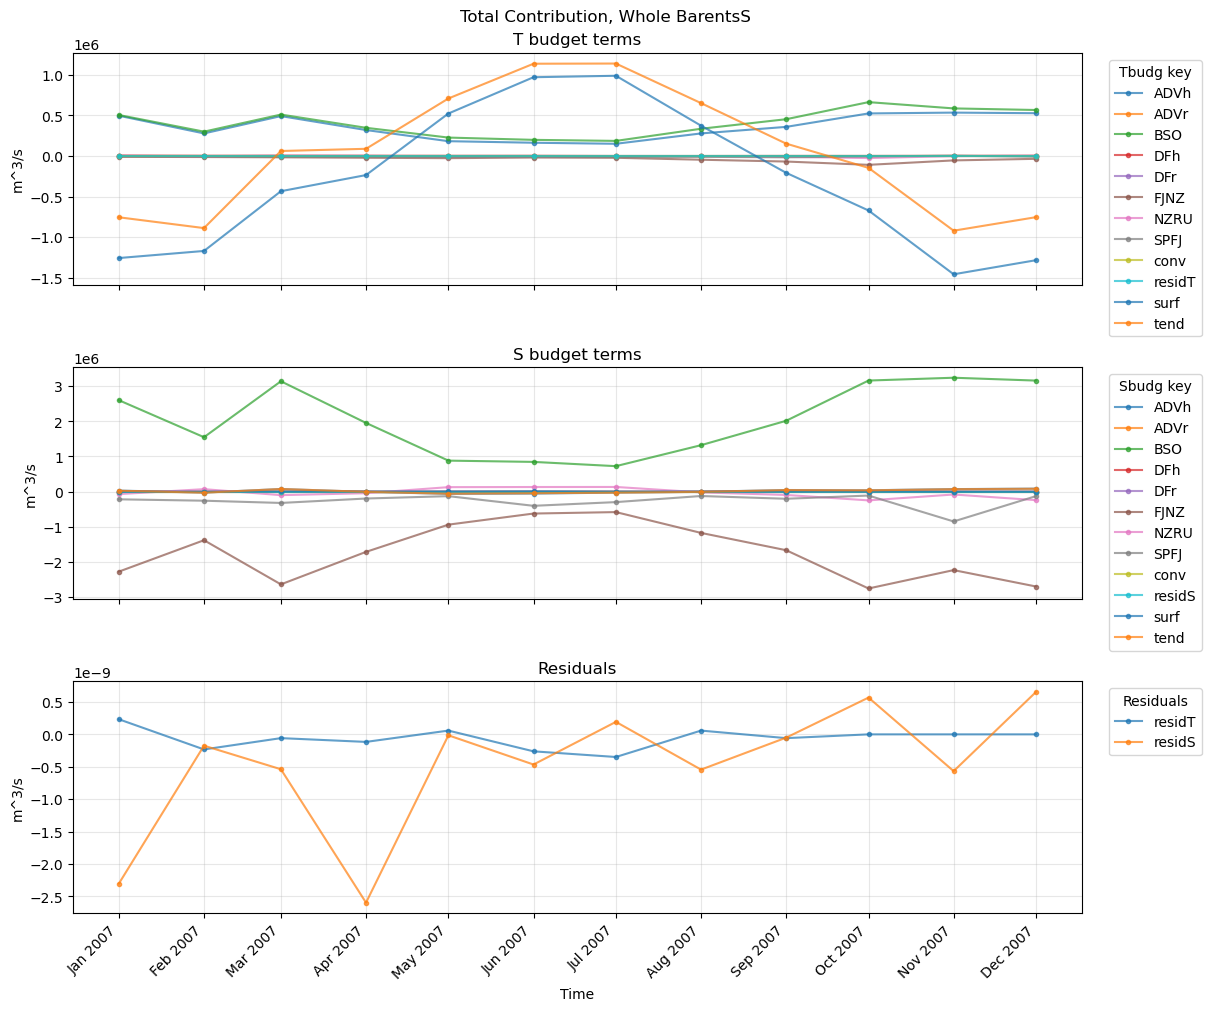

In [21]:
ts_names = list(out.keys())
x = datetimes[:-1]  # datetime-like list/array, recall these are saved at the end of the month we track

def collect_series(budg_name):
    all_keys = sorted({k for ts in ts_names for k in out[ts].get(budg_name, {}).keys()})
    vals_by_key = {
        k: [out[ts].get(budg_name, {}).get(k, np.nan) for ts in ts_names]
        for k in all_keys
    }
    return all_keys, vals_by_key

T_keys, T_vals = collect_series("Tbudg")
S_keys, S_vals = collect_series("Sbudg")

fig, (axT, axS, axR) = plt.subplots(
    3, 1, figsize=(12, 10), sharex=True, constrained_layout=True
)

# --- Tbudg (top) ---
for k, y in T_vals.items():
    axT.plot(x, y, marker=".", label=str(k),alpha=0.7)
axT.set_ylabel("m^3/s")
axT.set_title("T budget terms")
axT.grid(alpha=0.3)

# --- Sbudg (bottom) ---
for k, y in S_vals.items():
    axS.plot(x, y, marker=".", label=str(k),alpha=0.7)
axS.set_ylabel("m^3/s")
axS.set_title("S budget terms")
axS.grid(alpha=0.3)


# -- Zoomed residual plot --
axR.plot(x,residTs,marker = ".",label = "residT",alpha=0.7)
axR.plot(x,residSs,marker = ".",label = "residS",alpha=0.7)
axR.set_ylabel("m^3/s")
axR.set_title("Residuals")
axR.set_xlabel("Time")
axR.grid(alpha=0.3)

# month-year ticks
axT.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axT.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45, ha="right")

# legends (outside)
axT.legend(title="Tbudg key", bbox_to_anchor=(1.02, 1), loc="upper left")
axS.legend(title="Sbudg key", bbox_to_anchor=(1.02, 1), loc="upper left")
axR.legend(title="Residuals", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.suptitle("Total Contribution, Whole BarentsS")

# plt.savefig("proofofclosure.png",dpi=300)
plt.show()

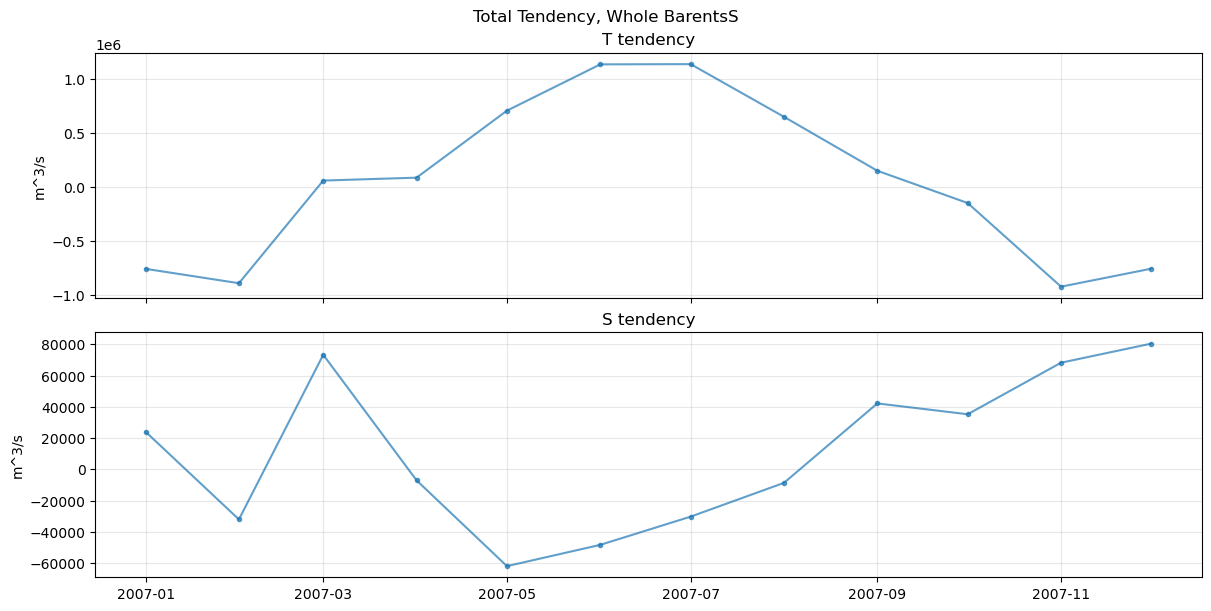

In [36]:
# check quickly if the salt tend is >0 and that there is a seasonal cycle
ts_names = list(out.keys())
x = datetimes[:-1]  # datetime-like list/array, recall these are saved at the end of the month we track

fig, (axT, axS) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True, constrained_layout=True
)

# --- Tbudg (top) ---
axT.plot(x, T_vals['tend'], marker=".", label=str(k),alpha=0.7)
axT.set_ylabel("m^3/s")
axT.set_title("T tendency")
axT.grid(alpha=0.3)

# --- Sbudg (bottom) 
axS.plot(x, S_vals['tend'], marker=".", label=str(k),alpha=0.7)
axS.set_ylabel("m^3/s")
axS.set_title("S tendency")
axS.grid(alpha=0.3)


plt.suptitle("Total Tendency, Whole BarentsS")

# plt.savefig("proofofclosure_proove.png",dpi=300)
plt.show()

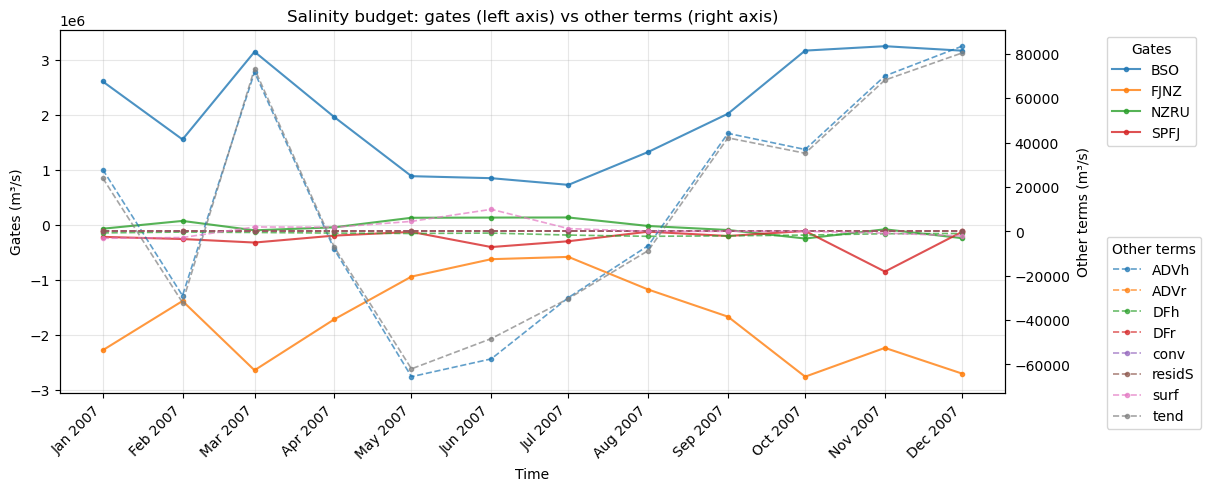

In [29]:
ts_names = list(out.keys())
x = datetimes[:-1]  # end-of-month timestamps

def collect_series(budg_name):
    all_keys = sorted({k for ts in ts_names for k in out[ts].get(budg_name, {}).keys()})
    vals_by_key = {
        k: np.asarray([out[ts].get(budg_name, {}).get(k, np.nan) for ts in ts_names], dtype=float)
        for k in all_keys
    }
    return all_keys, vals_by_key

S_keys, S_vals = collect_series("Sbudg")

gate_keys = ["BSO", "FJNZ", "NZRU", "SPFJ"]
other_keys = [k for k in S_keys if k not in gate_keys]

fig, axL = plt.subplots(1, 1, figsize=(12, 4.8), constrained_layout=True)
axR = axL.twinx()

# left axis: gates (solid)
for k in gate_keys:
    if k in S_vals:
        axL.plot(
            x, S_vals[k],
            marker=".", linestyle="-", linewidth=1.5,
            alpha=0.8, label=k
        )

# right axis: other terms (dashed)
for k in other_keys:
    axR.plot(
        x, S_vals[k],
        marker=".", linestyle="--", linewidth=1.2,
        alpha=0.7, label=str(k)
    )

axL.set_title("Salinity budget: gates (left axis) vs other terms (right axis)")
axL.set_ylabel("Gates (m³/s)")
axR.set_ylabel("Other terms (m³/s)")
axL.grid(alpha=0.3)
axL.set_xlabel("Time")

# month-year ticks
axL.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axL.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45, ha="right")

# legends outside (separate)
axL.legend(title="Gates", bbox_to_anchor=(1.1, 1.0), loc="upper left")
axR.legend(title="Other terms", bbox_to_anchor=(1.1, 0.45), loc="upper left")

plt.show()

In [30]:
term_colors = {
    "ADVr": "#d55e00",  # vermillion
    "DFh":  "#e69f00",  # orange
    "DFr":  "#009e73",  # green
    "surf": "#cc79a7",  # magenta
    "kpp":  "#6a3d9a",  # purple
}

# Gates: distinct cool/earth tones, avoiding overlap with term colors
gate_colors = {
    "BSO":  "#0072b2",  # blue
    "FJ":   "#56b4e9",  # light blue
    "SFJ":  "#999999",  # gray
    "FJNZ": "#1b9e77",  # teal (if this feels too close to DFr, swap with "#4daf4a")
}

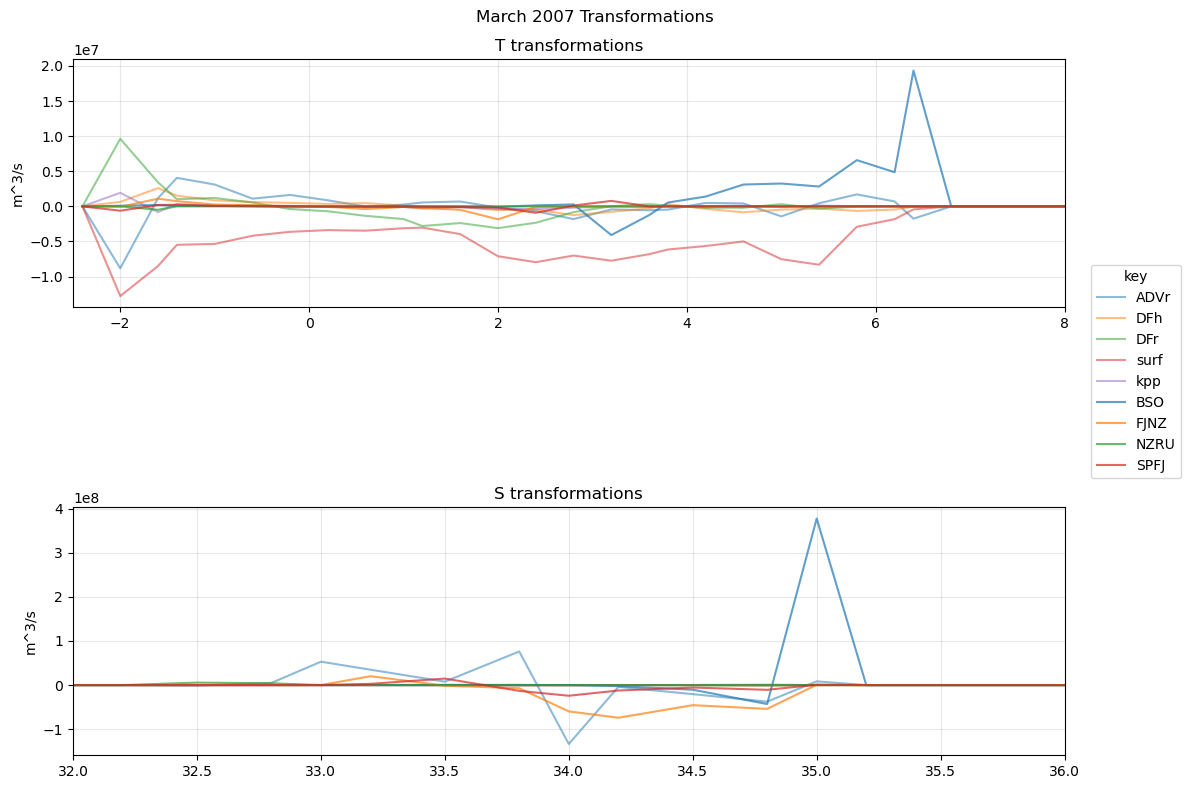

In [31]:
# --- configuration ---
TERM_ORDER = ["ADVr", "DFh", "DFr", "surf", "kpp"]     # the 5 “shared” terms
TERM_IDX   = {"ADVr": 1, "DFh": 2, "DFr": 3, "surf": 4, "kpp": 5}  # your current indexing
TERM_COLORS = {"ADVr":"C0","DFh":"C1","DFr":"C2","surf":"C3","kpp":"C4"}

def get_gate_colors(out_ts):
    gatesT = out_ts.get("gatesT", {})
    gatesS = out_ts.get("gatesS", {})
    gate_names = sorted(set(gatesT) | set(gatesS))
    cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    return gate_names, {g: cycle[i % len(cycle)] for i, g in enumerate(gate_names)}

def plot_panel(ax, x, G, gates, gate_names, gate_colors, xlim, title, alph=0.5):
    # shared terms
    for term in TERM_ORDER:
        y = np.asarray(G[TERM_IDX[term]]).copy()
        y[np.isnan(y)] = 0
        ax.plot(x, y, label=term, color=TERM_COLORS[term], alpha=alph)

    # gates (consistent colors across panels)
    for g in gate_names:
        if g not in gates:
            continue
        y = np.asarray(gates[g]).copy()
        y[np.isnan(y)] = 0
        ax.plot(x, y, label=g, color=gate_colors[g], alpha=0.7)

    ax.set_xlim(*xlim)
    ax.grid(alpha=0.3)
    ax.set_ylabel("m^3/s")
    ax.set_title(title)

def plot_ts(out, ts, boundsT, boundsS, suptitle=None):
    out_ts = out[ts]
    GT, GS = out_ts["GT"], out_ts["GS"]
    gatesT, gatesS = out_ts.get("gatesT", {}), out_ts.get("gatesS", {})

    xt = boundsT.flatten()[1:-1]
    xs = boundsS.flatten()[1:-1]

    gate_names, gate_colors = get_gate_colors(out_ts)

    fig, (axT, axS) = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

    plot_panel(axT, xt, GT, gatesT, gate_names, gate_colors,
               xlim=(-2.5, 8), title="T transformations")
    axT.legend(title="key", bbox_to_anchor=(1.02, 0.2), loc="upper left")

    plot_panel(axS, xs, GS, gatesS, gate_names, gate_colors,
               xlim=(32, 36), title="S transformations")

    if suptitle:
        fig.suptitle(suptitle)

    fig.tight_layout()
    return fig

# ---- usage ----
ts = tsstrfull[2]
fig = plot_ts(out, ts, boundsT, boundsS, suptitle="March 2007 Transformations")
# fig.savefig("March07.png", dpi=300, bbox_inches="tight")
plt.show()

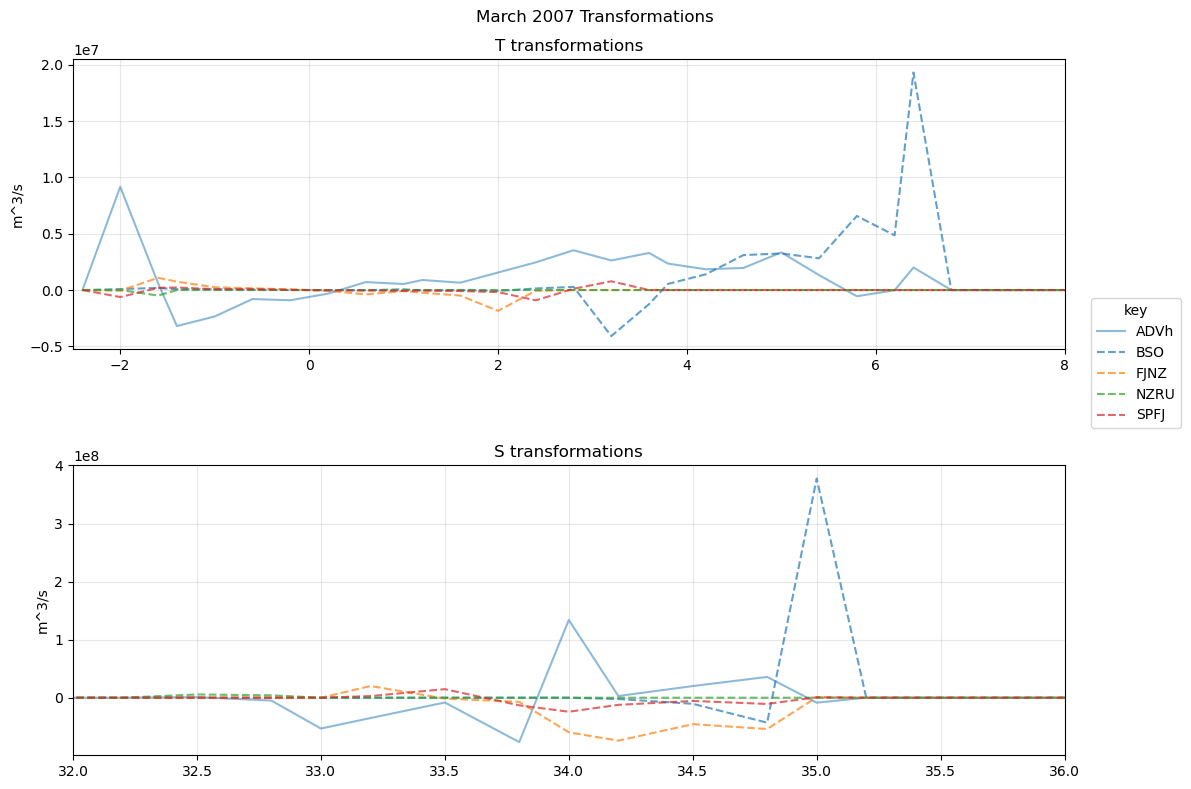

In [34]:
# we have to make our own custom plot for the third one

# --- configuration ---
TERM_ORDER = ["ADVh"]     # the 5 “shared” terms
TERM_IDX   = {"ADVh": 0}  # your current indexing
TERM_COLORS = {"ADVh":"C0"}

def get_gate_colors(out_ts):
    gatesT = out_ts.get("gatesT", {})
    gatesS = out_ts.get("gatesS", {})
    gate_names = sorted(set(gatesT) | set(gatesS))
    cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    return gate_names, {g: cycle[i % len(cycle)] for i, g in enumerate(gate_names)}

def plot_panel(ax, x, G, gates, gate_names, gate_colors, xlim, title, alph=0.5):
    # shared terms
    for term in TERM_ORDER:
        y = np.asarray(G[TERM_IDX[term]]).copy()
        y[np.isnan(y)] = 0
        ax.plot(x, y, label=term, color=TERM_COLORS[term], alpha=alph)

    # gates (consistent colors across panels)
    for g in gate_names:
        if g not in gates:
            continue
        y = np.asarray(gates[g]).copy()
        y[np.isnan(y)] = 0
        ax.plot(x, y, label=g, color=gate_colors[g], alpha=0.7,linestyle="--")

    ax.set_xlim(*xlim)
    ax.grid(alpha=0.3)
    ax.set_ylabel("m^3/s")
    ax.set_title(title)

def plot_ts(out, ts, boundsT, boundsS, suptitle=None):
    out_ts = out[ts]
    GT, GS = out_ts["GT"], out_ts["GS"]
    gatesT, gatesS = out_ts.get("gatesT", {}), out_ts.get("gatesS", {})

    xt = boundsT.flatten()[1:-1]
    xs = boundsS.flatten()[1:-1]

    gate_names, gate_colors = get_gate_colors(out_ts)

    fig, (axT, axS) = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

    plot_panel(axT, xt, GT, gatesT, gate_names, gate_colors,
               xlim=(-2.5, 8), title="T transformations")
    axT.legend(title="key", bbox_to_anchor=(1.02, 0.2), loc="upper left")

    plot_panel(axS, xs, GS, gatesS, gate_names, gate_colors,
               xlim=(32, 36), title="S transformations")

    if suptitle:
        fig.suptitle(suptitle)

    fig.tight_layout()
    return fig

# ---- usage ----
ts = tsstrfull[2]
fig = plot_ts(out, ts, boundsT, boundsS, suptitle="March 2007 Transformations")
# fig.savefig("March07.png", dpi=300, bbox_inches="tight")
plt.show()

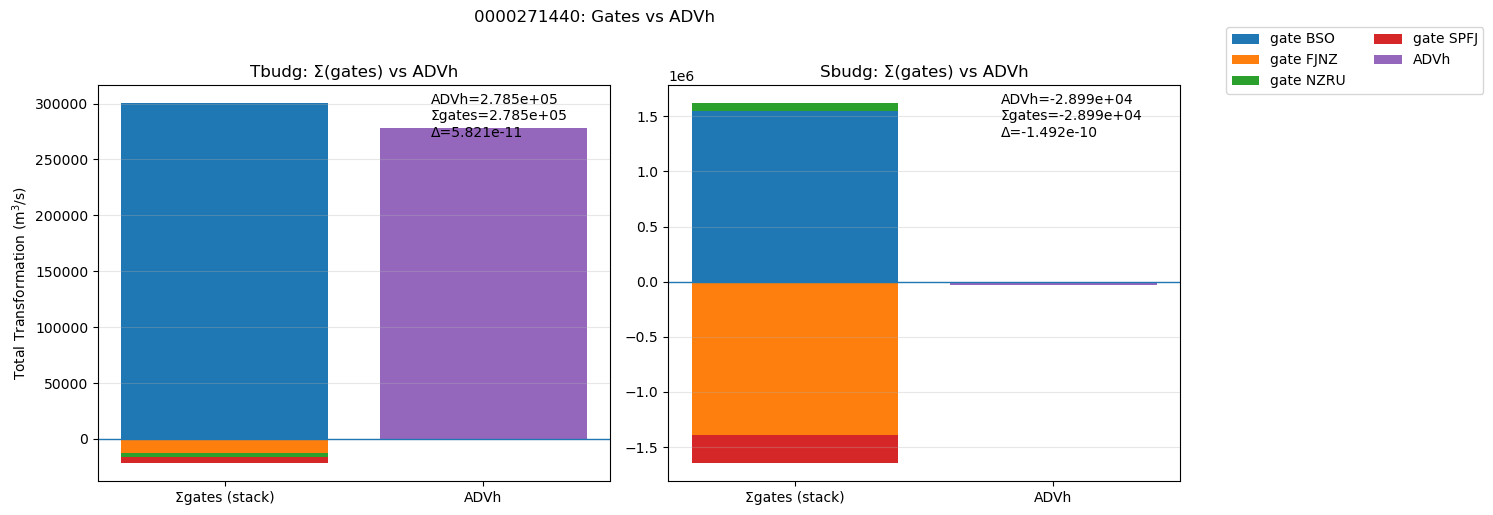

In [35]:
def stacked_posneg_bar(ax, x, terms, prefix=""):
    """Single stacked bar at x from {name: value}, stacking positives up and negatives down."""
    posbottom = 0.0
    negbottom = 0.0
    for name, val in terms.items():
        v = float(np.nan_to_num(val, nan=0.0))
        lab = f"{prefix}{name}"
        if v >= 0:
            ax.bar(x, v, bottom=posbottom, label=lab)
            posbottom += v
        else:
            ax.bar(x, v, bottom=negbottom, label=lab)
            negbottom += v
    return posbottom, negbottom

def as_scalar(x):
    x = np.asarray(x)
    return float(np.nansum(x)) if x.ndim else float(x)

ts = tsstrfull[2]
gate_keys = ["BSO", "FJNZ", "NZRU", "SPFJ"]  # edit if needed

Tbudg = out[ts]["Tbudg"]
Sbudg = out[ts]["Sbudg"]

T_gates = {k: as_scalar(Tbudg[k]) for k in gate_keys}
S_gates = {k: as_scalar(Sbudg[k]) for k in gate_keys}
T_advh  = as_scalar(Tbudg["ADVh"])
S_advh  = as_scalar(Sbudg["ADVh"])

fig, (axT, axS) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# --- T subplot ---
stacked_posneg_bar(axT, 0, T_gates, prefix="gate ")
axT.bar(1, T_advh, label="ADVh")
axT.axhline(0, linewidth=1)
axT.set_title("Tbudg: Σ(gates) vs ADVh")
axT.set_ylabel("Total Transformation (m$^3$/s)")
axT.grid(alpha=0.3, axis="y")
axT.text(
    0.65, 0.98,
    f"ADVh={T_advh:.3e}\nΣgates={sum(T_gates.values()):.3e}\nΔ={T_advh-sum(T_gates.values()):.3e}",
    transform=axT.transAxes, va="top"
)

# --- S subplot ---
stacked_posneg_bar(axS, 0, S_gates, prefix="gate ")
axS.bar(1, S_advh, label="ADVh")
axS.axhline(0, linewidth=1)
axS.set_title("Sbudg: Σ(gates) vs ADVh")
axS.grid(alpha=0.3, axis="y")
axS.text(
    0.65, 0.98,
    f"ADVh={S_advh:.3e}\nΣgates={sum(S_gates.values()):.3e}\nΔ={S_advh-sum(S_gates.values()):.3e}",
    transform=axS.transAxes, va="top"
)

for ax in (axT, axS):
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Σgates (stack)", "ADVh"])

# one shared legend for the whole figure
handles, labels = axT.get_legend_handles_labels()
h2, l2 = axS.get_legend_handles_labels()
seen = set()
uniq_h, uniq_l = [], []
for h, l in list(zip(handles, labels)) + list(zip(h2, l2)):
    if l not in seen:
        seen.add(l)
        uniq_h.append(h)
        uniq_l.append(l)

fig.legend(uniq_h, uniq_l, ncols=2, bbox_to_anchor=(1.02, 1), loc="upper left")

fig.suptitle(f"{ts}: Gates vs ADVh", y=1.02)
fig.tight_layout()
plt.show()

In [1]:
# stack these two plots

# ----------------------------
# shared config (edit as needed)
# ----------------------------
TERM_ORDER  = ["ADVh"]          # add more if you want
TERM_IDX    = {"ADVh": 0}       # ADVh index inside GT/GS arrays
TERM_COLORS = {"ADVh": "C0"}

gate_keys = ["BSO", "FJNZ", "NZRU", "SPFJ"]  # your gate terms in Tbudg/Sbudg

mpl.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "legend.title_fontsize": 14,
    "lines.linewidth": 2.5,
    "lines.markersize": 7,
})


# ----------------------------
# helpers: line panels (your style)
# ----------------------------
def get_gate_colors(out_ts):
    gatesT = out_ts.get("gatesT", {})
    gatesS = out_ts.get("gatesS", {})
    gate_names = sorted(set(gatesT) | set(gatesS))
    cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    return gate_names, {g: cycle[i % len(cycle)] for i, g in enumerate(gate_names)}

def plot_panel(ax, x, G, gates, gate_names, gate_colors, xlim, title, alph=0.5):
    # shared terms
    for term in TERM_ORDER:
        y = np.asarray(G[TERM_IDX[term]]).copy()
        y[np.isnan(y)] = 0.0
        ax.plot(x, y, label=term, color=TERM_COLORS[term], alpha=alph)

    # gates
    for g in gate_names:
        if g not in gates:
            continue
        y = np.asarray(gates[g]).copy()
        y[np.isnan(y)] = 0.0
        ax.plot(x, y, label=g, color=gate_colors[g], alpha=0.7, linestyle="--")

    ax.set_xlim(*xlim)
    ax.grid(alpha=0.3)
    ax.set_ylabel("m$^3$/s")
    ax.set_title(title)


# ----------------------------
# helpers: stacked bars
# ----------------------------
def stacked_posneg_bar(ax, x, terms, prefix=""):
    posbottom = 0.0
    negbottom = 0.0
    for name, val in terms.items():
        v = float(np.nan_to_num(val, nan=0.0))
        lab = f"{prefix}{name}"
        if v >= 0:
            ax.bar(x, v, bottom=posbottom, label=lab)
            posbottom += v
        else:
            ax.bar(x, v, bottom=negbottom, label=lab)
            negbottom += v
    return posbottom, negbottom

def as_scalar(x):
    x = np.asarray(x)
    return float(np.nansum(x)) if x.ndim else float(x)


# ----------------------------
# combined plot
# ----------------------------
def plot_ts_with_stack(out, ts, boundsT, boundsS, suptitle=None,
                       xlimT=(-2.5, 8), xlimS=(32, 36)):
    out_ts = out[ts]
    GT, GS = out_ts["GT"], out_ts["GS"]
    gatesT, gatesS = out_ts.get("gatesT", {}), out_ts.get("gatesS", {})

    # x-axes for transformations
    xt = boundsT.flatten()[1:-1]
    xs = boundsS.flatten()[1:-1]

    gate_names, gate_colors = get_gate_colors(out_ts)

    # ---- set up 2x2 layout
    fig, axes = plt.subplots(
        2, 2, figsize=(14, 9),
        gridspec_kw={"height_ratios": [2.2, 1.2]},
        constrained_layout=True
    )
    axT_line, axS_line = axes[0, 0], axes[0, 1]
    axT_bar,  axS_bar  = axes[1, 0], axes[1, 1]

    # ---- top row: line panels
    plot_panel(axT_line, xt, GT, gatesT, gate_names, gate_colors, xlim=xlimT, title="T transformations")
    plot_panel(axS_line, xs, GS, gatesS, gate_names, gate_colors, xlim=xlimS, title="S transformations")

    # ---- bottom row: stacked bars from Tbudg/Sbudg
    Tbudg = out_ts.get("Tbudg", {})
    Sbudg = out_ts.get("Sbudg", {})

    T_gates = {k: as_scalar(Tbudg.get(k, np.nan)) for k in gate_keys}
    S_gates = {k: as_scalar(Sbudg.get(k, np.nan)) for k in gate_keys}
    T_advh  = as_scalar(Tbudg.get("ADVh", np.nan))
    S_advh  = as_scalar(Sbudg.get("ADVh", np.nan))

    # T bars
    stacked_posneg_bar(axT_bar, 0, T_gates, prefix="gate ")
    axT_bar.bar(1, T_advh, label="ADVh")
    axT_bar.axhline(0, linewidth=1)
    axT_bar.set_title("Tbudg: Σ(gates) vs ADVh")
    axT_bar.set_ylabel("Total (m$^3$/s)")
    axT_bar.grid(alpha=0.3, axis="y")
    axT_bar.set_xticks([0, 1])
    axT_bar.set_xticklabels(["Σgates (stack)", "ADVh"])
    axT_bar.text(
        0.62, 0.98,
        f"ADVh={T_advh:.3e}\nΣgates={sum(T_gates.values()):.3e}\nΔ={T_advh-sum(T_gates.values()):.3e}",
        transform=axT_bar.transAxes, va="top"
    )

    # S bars
    stacked_posneg_bar(axS_bar, 0, S_gates, prefix="gate ")
    axS_bar.bar(1, S_advh, label="ADVh")
    axS_bar.axhline(0, linewidth=1)
    axS_bar.set_title("Sbudg: Σ(gates) vs ADVh")
    axS_bar.grid(alpha=0.3, axis="y")
    axS_bar.set_xticks([0, 1])
    axS_bar.set_xticklabels(["Σgates (stack)", "ADVh"])
    axS_bar.text(
        0.62, 0.98,
        f"ADVh={S_advh:.3e}\nΣgates={sum(S_gates.values()):.3e}\nΔ={S_advh-sum(S_gates.values()):.3e}",
        transform=axS_bar.transAxes, va="top"
    )

    # ---- one shared legend (unique labels)
    handles, labels = [], []
    for ax in (axT_line, axS_line, axT_bar, axS_bar):
        h, l = ax.get_legend_handles_labels()
        handles += h
        labels += l

    seen = set()
    uniq_h, uniq_l = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            uniq_h.append(h)
            uniq_l.append(l)

    fig.legend(uniq_h, uniq_l, ncols=2, bbox_to_anchor=(1.02, 1), loc="upper left")

    if suptitle:
        fig.suptitle(suptitle, y=1.02)
    else:
        fig.suptitle(f"{ts}: Transformations + Gates vs ADVh", y=1.02)

    return fig


# ---- usage
ts = tsstrfull[2]
fig = plot_ts_with_stack(out, ts, boundsT, boundsS, suptitle="March 2007 Transformations")
plt.show()

NameError: name 'mpl' is not defined

## Let's define the climatology and save this to a separate file for 2006--2017

This is where we note a shift in the ocean state re ASTE paper

In [18]:
# ------------------------------------------------------------
# 1) Build (year, month) -> tsstr mapping for monthly means
#    Monthly mean for month m uses [m/1, (m+1)/1] (Dec uses Jan next year)
#    Period: 2006–2017, so we also need Jan 2018 for Dec 2017.
# ------------------------------------------------------------
years_clim = np.arange(2006, 2018)          # 2006..2017 (inclusive)
years_req  = np.arange(2006, 2019)          # 2006..2018 (need Jan 2018)

times = {str(y): np.arange(1, 13) for y in years_req}
times[str(2018)] = np.array([1])            # only Jan 2018 needed

tsstr_sel, dts_sel = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)
tindex = pd.DatetimeIndex(dts_sel)
tsstr_sel = np.asarray(tsstr_sel)

# Map (year, month) -> tsstr (string)
ts_by_ym = {(dt.year, dt.month): ts for dt, ts in zip(tindex, tsstr_sel)}

# bins / shapes (for zero-fill if a gate is missing)
xt = boundsT.flatten()[1:-1]
xs = boundsS.flatten()[1:-1]
nT, nS = len(xt), len(xs)

# ------------------------------------------------------------
# 2) Loop over all months in 2006–2017, run gates_check, save ALL outputs
# ------------------------------------------------------------
out = {}  # keyed by ts_end (first of subsequent month), like your existing pattern

# also accumulate by calendar month for climatology
by_month = {m: {"GT": [], "GS": [], "gatesT": [], "gatesS": [], "Tbudg": [], "Sbudg": []}
            for m in range(1, 13)}

gateT_keys = None
gateS_keys = None

for y in years_clim:
    print("YEAR",y,"done")
    for m in range(1, 13):
        # timestep pair: start-of-month to start-of-next-month
        y2, m2 = (y, m + 1) if m < 12 else (y + 1, 1)
        ts_pair = np.array([ts_by_ym[(y, m)], ts_by_ym[(y2, m2)]])

        Tdict, Sdict, G_T_offline, G_S_offline, gatesT, gatesS = gates_check(ts_pair,mymsk)

        ts_key = ts_pair[-1]  # "marked on the first of the subsequent month"

        out[ts_key] = {
            "year": y,
            "month": m,
            "ts_pair": ts_pair,
            "Tbudg": Tdict,
            "Sbudg": Sdict,
            "GT": G_T_offline,
            "GS": G_S_offline,
            "gatesT": gatesT,
            "gatesS": gatesS,
        }

        # establish a consistent gate order (first successful call)
        if gateT_keys is None:
            gateT_keys = list(gatesT.keys())
        if gateS_keys is None:
            gateS_keys = list(gatesS.keys())

        # pack gates into arrays with consistent ordering (missing -> zeros)
        gT = np.vstack([np.nan_to_num(np.asarray(gatesT.get(k, np.zeros(nT))), nan=0.0) for k in gateT_keys])
        gS = np.vstack([np.nan_to_num(np.asarray(gatesS.get(k, np.zeros(nS))), nan=0.0) for k in gateS_keys])

        by_month[m]["GT"].append(G_T_offline)
        by_month[m]["GS"].append(G_S_offline)
        by_month[m]["gatesT"].append(gT)
        by_month[m]["gatesS"].append(gS)
        by_month[m]["Tbudg"].append(Tdict)
        by_month[m]["Sbudg"].append(Sdict)

print("saved monthly outputs for:", len(out), "months")

# ------------------------------------------------------------
# 3) Build climatologies (mean across years) for each calendar month
# ------------------------------------------------------------
def _nanmean_stack(list_of_arrays):
    A = np.stack(list_of_arrays, axis=0)
    return np.nanmean(A, axis=0)

def _nanmean_dict(list_of_dicts):
    # mean each key across years; values can be scalars or arrays (assumed consistent shapes)
    keys = sorted(set().union(*[d.keys() for d in list_of_dicts]))
    outd = {}
    for k in keys:
        vals = []
        for d in list_of_dicts:
            if k not in d:
                continue
            v = np.asarray(d[k], dtype=float)
            vals.append(np.nan_to_num(v, nan=0.0))
        if not vals:
            continue
        outd[k] = np.nanmean(np.stack(vals, axis=0), axis=0)
    return outd

clim = {
    "meta": {
        "years": years_clim,
        "gateT_keys": gateT_keys,
        "gateS_keys": gateS_keys,
    },
    "monthly": {}
}

for m in range(1, 13):
    clim["monthly"][m] = {
        "GT":     _nanmean_stack(by_month[m]["GT"]),
        "GS":     _nanmean_stack(by_month[m]["GS"]),
        "gatesT": _nanmean_stack(by_month[m]["gatesT"]),
        "gatesS": _nanmean_stack(by_month[m]["gatesS"]),
        "Tbudg":  _nanmean_dict(by_month[m]["Tbudg"]),
        "Sbudg":  _nanmean_dict(by_month[m]["Sbudg"]),
    }

print("built climatology for months 1..12")

YEAR 2006 done
gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: 139557.49639929173
gates S: 139557.49639928748

calc tend 134996.1116968834
tend 134996.1116968834
other terms -4561.384702408327
resid 4.249159246683121e-09

temp check
ADVhT: 629388.888404799
gates T: 629388.888404799
calc tend -643407.393427037
tend -643407.3934270372
-1272796.2818318359
resid -3.4924596548080444e-10

gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: -34238.1780390554
gates S: -34238.17803905517

calc tend -39254.96728076529
tend -39254.9672807653
other terms -5016.789241709749
resid -3.7834979593753815e-10

temp check
ADVhT: 443065.1512833532
gates T: 443065.1512833533
calc tend -794396.776981527
tend -794396.776981527
-1237461.9282648803
resid 5.820766091346741e-11

gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: -6283.854158268344
gates S: -6283.854158265924

calc tend -9477.754960468092
tend -9477.75496046809
other terms -3193.9008021997015
resid -2

In [10]:
mymsk2.shape

(1350, 270)

In [19]:
# ------------------------------------------------------------
# 4) Save + load (npz with pickled python objects)
# ------------------------------------------------------------
path = "/scratch/mmurakami/ASTE_270/ASTER1_offline_terms/"
np.savez(
    path + "wmt_gates_monthly_and_climatology_2006_2017_BarentsS.npz",
    out=np.array(out, dtype=object),
    clim=np.array(clim, dtype=object),
    allow_pickle=True,
)

# I think we need to do this for a smaller section (northern) and get the climatology

In [11]:
# let's create the northern climatology so we can look at OHC and sea ice concentration for these


# ------------------------------------------------------------
# 1) Build (year, month) -> tsstr mapping for monthly means
#    Monthly mean for month m uses [m/1, (m+1)/1] (Dec uses Jan next year)
#    Period: 2006–2017, so we also need Jan 2018 for Dec 2017.
# ------------------------------------------------------------
years_clim = np.arange(2006, 2018)          # 2006..2017 (inclusive)
years_req  = np.arange(2006, 2019)          # 2006..2018 (need Jan 2018)

times = {str(y): np.arange(1, 13) for y in years_req}
times[str(2018)] = np.array([1])            # only Jan 2018 needed

tsstr_sel, dts_sel = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)
tindex = pd.DatetimeIndex(dts_sel)
tsstr_sel = np.asarray(tsstr_sel)
dt_by_ts = {ts: dt for ts, dt in zip(tsstr_sel, tindex)}  # for the correct dt

# Map (year, month) -> tsstr (string)
ts_by_ym = {(dt.year, dt.month): ts for dt, ts in zip(tindex, tsstr_sel)}

# bins / shapes (for zero-fill if a gate is missing)
xt = boundsT.flatten()[1:-1]
xs = boundsS.flatten()[1:-1]
nT, nS = len(xt), len(xs)

# ------------------------------------------------------------
# 2) Loop over all months in 2006–2017, run gates_check, save ALL outputs
# ------------------------------------------------------------
out = {}  # keyed by ts_end (first of subsequent month), like your existing pattern

# also accumulate by calendar month for climatology
by_month = {m: {"GT": [], "GS": [], "gatesT": [], "gatesS": [], "Tbudg": [], "Sbudg": []}
            for m in range(1, 13)}

gateT_keys = None
gateS_keys = None

for y in years_clim:
    print("YEAR",y,"done")
    for m in range(1, 13):
        # timestep pair: start-of-month to start-of-next-month
        y2, m2 = (y, m + 1) if m < 12 else (y + 1, 1)
        ts_pair = np.array([ts_by_ym[(y, m)], ts_by_ym[(y2, m2)]])

        dt0 = dt_by_ts[ts_pair[0]]
        dt1 = dt_by_ts[ts_pair[1]]
        dt = (dt1 - dt0).total_seconds()

        Tdict, Sdict, G_T_offline, G_S_offline, gatesT, gatesS = gates_check(ts_pair,mymsk2,dt,half=True)

        ts_key = ts_pair[-1]  # "marked on the first of the subsequent month"

        out[ts_key] = {
            "year": y,
            "month": m,
            "ts_pair": ts_pair,
            "Tbudg": Tdict,
            "Sbudg": Sdict,
            "GT": G_T_offline,
            "GS": G_S_offline,
            "gatesT": gatesT,
            "gatesS": gatesS,
        }

        # establish a consistent gate order (first successful call)
        if gateT_keys is None:
            gateT_keys = list(gatesT.keys())
        if gateS_keys is None:
            gateS_keys = list(gatesS.keys())

        # pack gates into arrays with consistent ordering (missing -> zeros)
        gT = np.vstack([np.nan_to_num(np.asarray(gatesT.get(k, np.zeros(nT))), nan=0.0) for k in gateT_keys])
        gS = np.vstack([np.nan_to_num(np.asarray(gatesS.get(k, np.zeros(nS))), nan=0.0) for k in gateS_keys])

        by_month[m]["GT"].append(G_T_offline)
        by_month[m]["GS"].append(G_S_offline)
        by_month[m]["gatesT"].append(gT)
        by_month[m]["gatesS"].append(gS)
        by_month[m]["Tbudg"].append(Tdict)
        by_month[m]["Sbudg"].append(Sdict)

print("saved monthly outputs for:", len(out), "months")

# ------------------------------------------------------------
# 3) Build climatologies (mean across years) for each calendar month
# ------------------------------------------------------------
def _nanmean_stack(list_of_arrays):
    A = np.stack(list_of_arrays, axis=0)
    return np.nanmean(A, axis=0)

def _nanmean_dict(list_of_dicts):
    # mean each key across years; values can be scalars or arrays (assumed consistent shapes)
    keys = sorted(set().union(*[d.keys() for d in list_of_dicts]))
    outd = {}
    for k in keys:
        vals = []
        for d in list_of_dicts:
            if k not in d:
                continue
            v = np.asarray(d[k], dtype=float)
            vals.append(np.nan_to_num(v, nan=0.0))
        if not vals:
            continue
        outd[k] = np.nanmean(np.stack(vals, axis=0), axis=0)
    return outd

clim = {
    "meta": {
        "years": years_clim,
        "gateT_keys": gateT_keys,
        "gateS_keys": gateS_keys,
    },
    "monthly": {}
}

for m in range(1, 13):
    clim["monthly"][m] = {
        "GT":     _nanmean_stack(by_month[m]["GT"]),
        "GS":     _nanmean_stack(by_month[m]["GS"]),
        "gatesT": _nanmean_stack(by_month[m]["gatesT"]),
        "gatesS": _nanmean_stack(by_month[m]["gatesS"]),
        "Tbudg":  _nanmean_dict(by_month[m]["Tbudg"]),
        "Sbudg":  _nanmean_dict(by_month[m]["Sbudg"]),
    }

print("built climatology for months 1..12")

YEAR 2006 done
gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: 70528.10054454423
gates S: 70528.10054454533

calc tend 69147.85748577738
tend 69147.85748577738
other terms -1380.243058766848
resid -1.1059455573558807e-09

temp check
ADVhT: 98247.93309781203
gates T: 98247.93309781203
calc tend -102796.26619068536
tend -102796.26619068538
-201044.1992884974
resid -1.4551915228366852e-11

gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: -14114.575701823393
gates S: -14114.575701823458

calc tend -18312.027101977234
tend -18312.027101977234
other terms -4197.451400153652
resid -1.2369127944111824e-10

temp check
ADVhT: 150689.01565454484
gates T: 150689.01565454487
calc tend -69899.26352025065
tend -69899.26352025064
-220588.27917479543
resid -5.820766091346741e-11

gates calculated
G_T calculated
G_S calculated

salt check
ADVhS: -5498.519500027964
gates S: -5498.519500028109

calc tend -8252.495720427112
tend -8252.495720427112
other terms -2753.976220

In [12]:
# ------------------------------------------------------------
# 4) Save + load (npz with pickled python objects)
# ------------------------------------------------------------
path = "/scratch/mmurakami/ASTE_270/ASTER1_offline_terms/"
np.savez(
    path + "wmt_gates_monthly_and_climatology_2006_2017_BarentsS_N_half.npz",
    out=np.array(out, dtype=object),
    clim=np.array(clim, dtype=object),
    allow_pickle=True,
)